# EDA

**Исходные данные:** .tif спутниковый снимок, .tif маска с геоданными.

**Цель:** обучить модель Unet для сегментации леса на спутниковых снимках

**План выполнения EDA:**
1. Визуализация изображений
2. Получение основной информации о снимках. Размер, геоданные, количество каналов и так далее
3. Разделение снимка и маски на патчи определенного размера. Их визуализация
4. Формирование датасетов train, val, test, создание соответствующих папок

Количество объектов (деревьев):
* *зеленые*: 2762
* *желтые*: 1087
* *красные*: 566
* *всего*: 4415

Цвета на маске:

* 55,96,255 -- красный
* 55,250,250 -- желтый
* 83,179,36 -- зеленый

## Импорт необходимых библиотек

In [1]:
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2

## Функции

### Создание директорий для данных

In [3]:
def create_dirs(base_dir: str) -> None:
    """
    Создает директории под train, test, val выборки, в которых будут храниться патчи

    :param
        base_dir: Базовая директория для патчей
    :return:
        None: ничего
    """
    os.makedirs(base_dir, exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'train/images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'train/labels'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test/images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test/labels'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val/images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val/labels'), exist_ok=True)

### Получение основной информации об изображении

In [4]:
def get_info(path_to_image: str) -> None:
    """
    Выводит основную информацию об изображении

    :return:
        None: ничего
    """
    with rasterio.open(path_to_image) as src:
        print("✅ Основная информация:")
        print(f"- Ширина: {src.width}")
        print(f"- Высота: {src.height}")
        print(f"- Количество пикселей: {src.width * src.height}")
        print(f"- Количество каналов: {src.count}")
        print(f"- Тип данных: {src.dtypes}")
        print(f"- CRS (система координат): {src.crs}")
        print(f"- Transform (геопривязка): {src.transform}")
        print()

        print("🧾 Полные метаданные (src.meta):")
        print(src.meta)

### Получение rgb разложение изображения

In [5]:
def get_image_array(path_to_image: str) -> np.ndarray:
    """
    Получаем изображение в виде матрицы формы (height, width, channels)

    :return:
        np.ndarray: Матрица
    """
    return np.array(Image.open(path_to_image))

### Визуализация изображения

In [6]:
def visualization_image(path_to_image: str) -> None:
    """
    Визуализируем изображение с помощью matplotlib

    :return:
        None: ничего
    """
    rgb = get_image_array(path_to_image)

    plt.figure(figsize=(10, 15))
    plt.imshow(rgb)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

### Подсчет количества меток определенного цвета на маске

In [7]:
def count_pixels_by_color(path_to_image: str) -> dict:
    """
    Считаем количество пикселей разных цветов на маске

    :return:
        dict: Словарь с количеством пикселей по цветам на маске
    """
    image = cv2.imread(path_to_image)

    color_counts = {
        'red': 0,
        'yellow': 0,
        'green': 0,
        'black': 0
    }

    # Определим цвета в BGR (OpenCV использует BGR)
    colors_bgr = {
        'red':    ([55, 96, 255], [55, 96, 255]),
        'yellow': ([55, 250, 250], [55, 250, 250]),
        'green':  ([83, 179, 36], [83, 179, 36]),
        'black':  ([0, 0, 0], [0, 0, 0])
    }

    for color, (lower, upper) in colors_bgr.items():
        mask = cv2.inRange(image, np.array(lower), np.array(upper))
        count = cv2.countNonZero(mask)
        color_counts[color] = count

    return color_counts

### Нарезание изображения на патчи

In [8]:
def slice_image(path_to_image: str, size: int) -> list:
    """
    Нарезает исходное изображение на патчи со стороной размера size

    :param
        size: размер стороны патча
    :return:
        None: ничего
    """
    image = get_image_array(path_to_image)

    patches = []

    height, width, channels = image.shape
    h_steps = (height + size - 1) // size
    w_steps = (width + size - 1) // size

    for h in range(h_steps):
        for w in range(w_steps):

            start_h = h * size
            start_w = w * size
            end_h = min(start_h + size, height)
            end_w = min(start_w + size, width)


            patch = image[start_h:end_h, start_w:end_w, :]


            if patch.shape[0] < size or patch.shape[1] < size:
                padded_patch = np.zeros((size, size, channels), dtype=patch.dtype)
                padded_patch[:patch.shape[0], :patch.shape[1], :] = patch
                patch = padded_patch

            patches.append(patch)

    return patches

### Сохранение патчей в виде .png изображений

In [9]:
def save_patches(patches: list, labels: list, split_type: str, base_dir: str, prefix: str) -> None:
    for i, (patch, label) in enumerate(zip(patches, labels)):
        img = Image.fromarray(patch)
        img.save(os.path.join(base_dir, f'{split_type}/images/{prefix}_{i}.png'))

        label_img = Image.fromarray(label)
        label_img.save(os.path.join(base_dir, f'{split_type}/labels/{prefix}_{i}.png'))

## Исходный спутниковый снимок

### Путь до изображения

In [10]:
path_to_orig = 'data/satellite_image.tif'

### Получение основной информации

In [11]:
get_info(path_to_orig)

✅ Основная информация:
- Ширина: 5930
- Высота: 10759
- Количество пикселей: 63800870
- Количество каналов: 3
- Тип данных: ('uint8', 'uint8', 'uint8')
- CRS (система координат): EPSG:32640
- Transform (геопривязка): | 0.05, 0.00, 468337.42|
| 0.00,-0.05, 6464039.86|
| 0.00, 0.00, 1.00|

🧾 Полные метаданные (src.meta):
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5930, 'height': 10759, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northi

### Визуализация

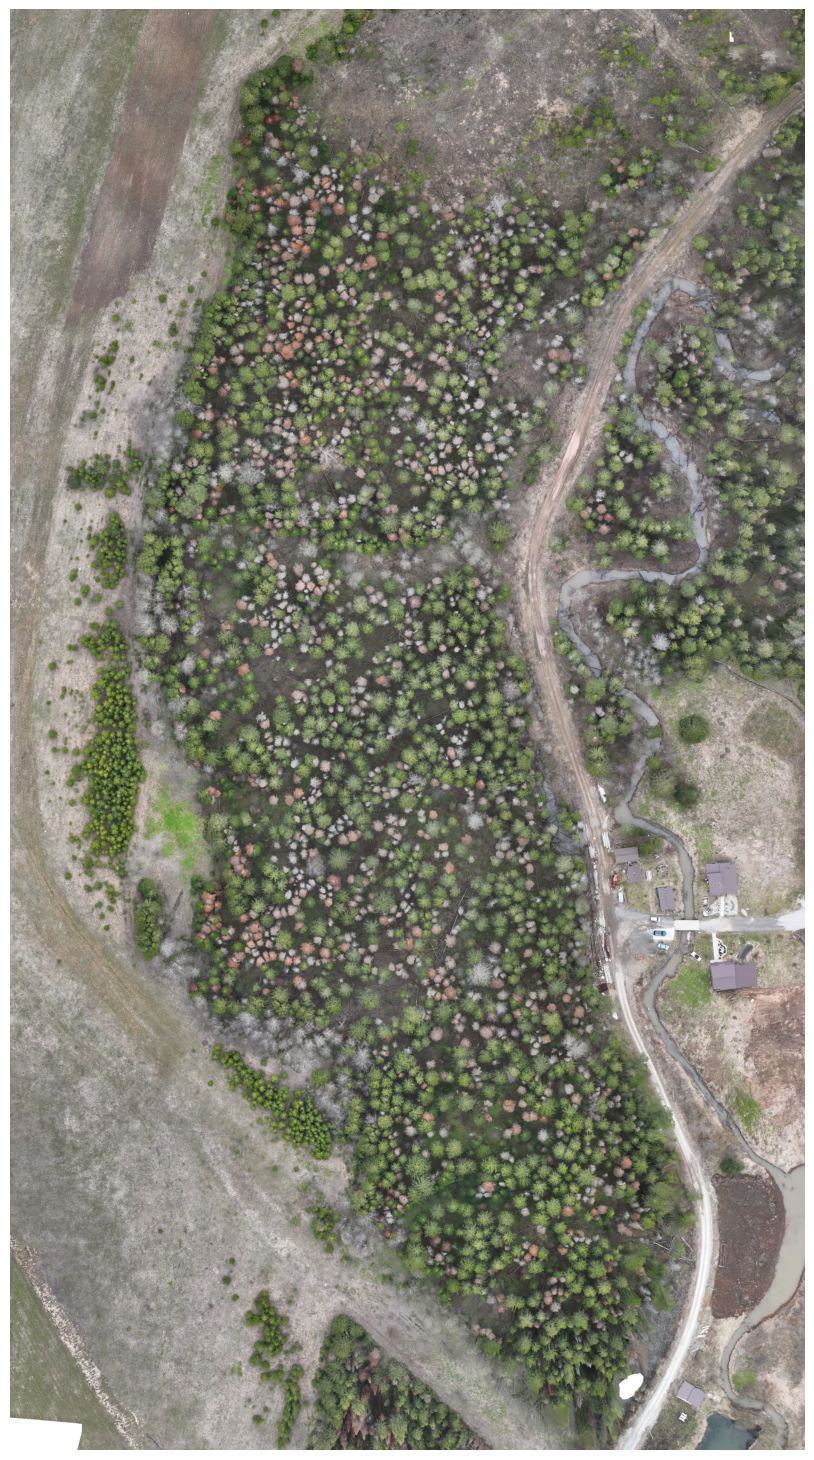

In [12]:
visualization_image(path_to_orig)

## Маска

### Путь до изображения

In [13]:
path_to_mask = 'data/mask.tif'

### Получение основной информации

In [14]:
get_info(path_to_mask)

✅ Основная информация:
- Ширина: 5930
- Высота: 10759
- Количество пикселей: 63800870
- Количество каналов: 3
- Тип данных: ('uint8', 'uint8', 'uint8')
- CRS (система координат): EPSG:32640
- Transform (геопривязка): | 0.05, 0.00, 468337.42|
| 0.00,-0.05, 6464039.86|
| 0.00, 0.00, 1.00|

🧾 Полные метаданные (src.meta):
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5930, 'height': 10759, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northi

### Визуализация

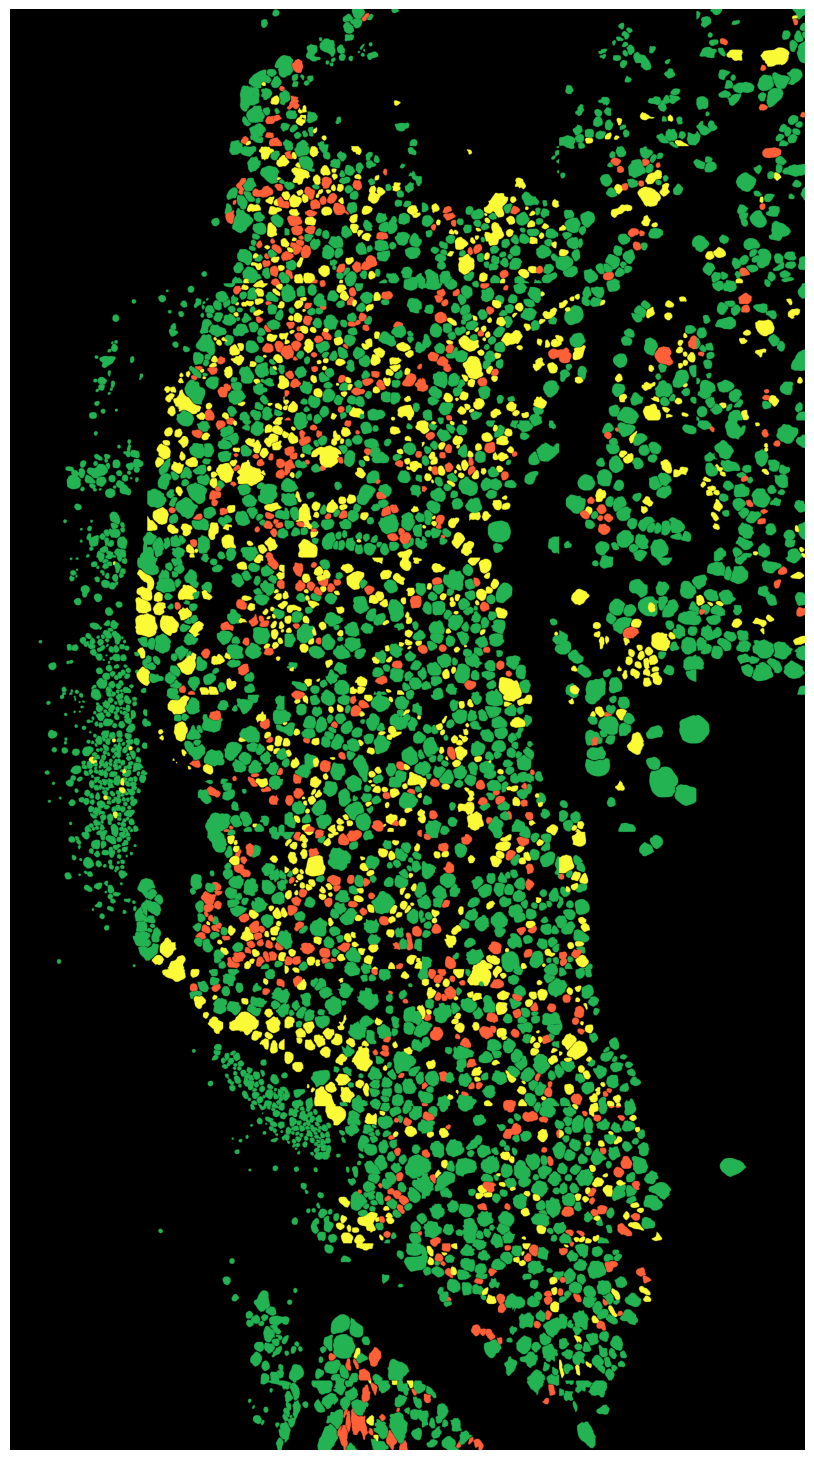

In [15]:
visualization_image(path_to_mask)

### Подсчет пикселей

In [16]:
count_pixels_by_color(path_to_mask)

{'red': 1702202, 'yellow': 3290532, 'green': 11578458, 'black': 47229678}

## Разделение изображений на патчи и сохранение в папки

In [17]:
create_dirs('data/')

patches_orig = slice_image(path_to_orig, 256)
patches_mask = slice_image(path_to_mask, 256)

train_images, test_images, train_labels, test_labels = train_test_split(patches_orig, patches_mask, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.50, random_state=42)

save_patches(train_images, train_labels, 'train', 'data/', 'patch')
save_patches(val_images, val_labels, 'val', 'data/', 'patch')
save_patches(test_images, test_labels, 'test', 'data/', 'patch')

TODO: Дописать для двух изображений. Исходные изображения не добавлять в репозиторий, а положить на яндекс диск и сделать ссылку. README.md для запуска